코드에 필요한 모듈들을 import 한다.

In [2]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

Using TensorFlow backend.


이미지의 사이즈를 맞추고, path를 다음과 같이 설정한다.

In [3]:
im_width = 101
im_height = 101
im_chan = 1
basicpath = 'D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

다음은 upsample과 downsample을 위한 함수이다.

In [4]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

train dataset과 test dataset을 다음과 같은 과정을 통해서 불러온다.  

In [5]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

이미지 픽셀 값을 255로 나누어주어 normalization을 진행한다.

In [6]:
train_df["images"] = [np.array(load_img("D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


마스크 픽셀 값을 255로 나누어주어 normalization을 진행한다.

In [7]:
train_df["masks"] = [np.array(load_img("D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

train_df.coverage 와 train_df.coverage_class에 대해 시각화한다.

Text(0.5, 0, 'Coverage class')

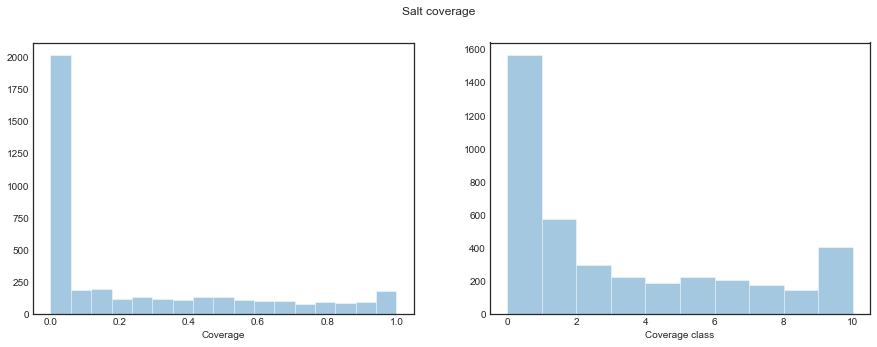

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Train과 Test set의 depth의 범위에 대해 시각화한다.

Text(0.5, 1.0, 'Depth distribution')

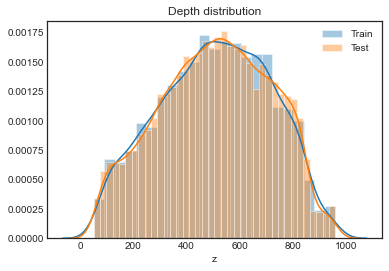

In [10]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [11]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

convolution block 과 residual block에 관한 함수를 만들고, model 생성에 이용한다.  
BatchNormalization을 포함시킨다. 

In [12]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation('relu')(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

아래는 model structure이다.

In [13]:
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation('relu')(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

평가 지표로 활용되는 IoU에 대한 함수이다.

In [14]:
#Score the model and do a threshold optimization by the best IoU.

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    # Jiaxin fin that if all zeros, then, the background is treated as object
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
# Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn
# Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("metric = ",metric)
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

Data augmentation 과정이다.

In [15]:
#Data augmentation
x_train2 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train2 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train2.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


Model을 compile 한다.

In [16]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
# input_layer2 = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

# del model
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric])

model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
_____________

early_stopping을 통해 4epoch 이상 모델의 성능이 개선되지 않으면 stop한다.  
총 epoch는 200회이며 batch size는 64로 설정했다.

In [17]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=4, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 64

history = model.fit(x_train2, y_train2,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/200


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


 - 90s - loss: 0.4005 - my_iou_metric: 0.1520 - val_loss: 0.8222 - val_my_iou_metric: 0.1327

Epoch 00001: val_my_iou_metric improved from -inf to 0.13269, saving model to ./unet_best1.model
Epoch 2/200
 - 76s - loss: 0.2814 - my_iou_metric: 0.3481 - val_loss: 2.0088 - val_my_iou_metric: 0.1327

Epoch 00002: val_my_iou_metric did not improve from 0.13269
Epoch 3/200
 - 76s - loss: 0.2503 - my_iou_metric: 0.4310 - val_loss: 2.0012 - val_my_iou_metric: 0.1327

Epoch 00003: val_my_iou_metric did not improve from 0.13269
Epoch 4/200
 - 76s - loss: 0.2296 - my_iou_metric: 0.5001 - val_loss: 1.2107 - val_my_iou_metric: 0.1768

Epoch 00004: val_my_iou_metric improved from 0.13269 to 0.17680, saving model to ./unet_best1.model
Epoch 5/200
 - 76s - loss: 0.2121 - my_iou_metric: 0.5337 - val_loss: 0.9811 - val_my_iou_metric: 0.1873

Epoch 00005: val_my_iou_metric improved from 0.17680 to 0.18726, saving model to ./unet_best1.model
Epoch 6/200
 - 76s - loss: 0.1933 - my_iou_metric: 0.5669 - val_l

matplotlib으로 표현한 epoch 증가에 따른 model loss의 변화이다.  
오렌지색이 validation set의 loss 변화, 파란색이 train set의 loss 변화이다.  


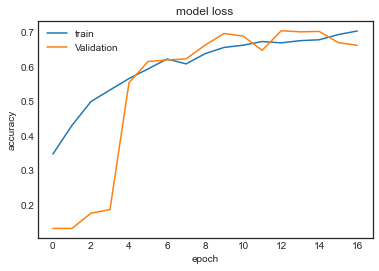

In [36]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

Loss의 추세를 epoch의 증가에 따라 표현했다.  

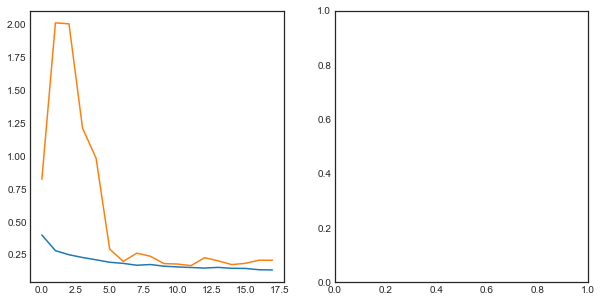

In [34]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

unet_best1.model을 load한다.

In [35]:
model = load_model("./unet_best1.model",custom_objects={'my_iou_metric': my_iou_metric})

predict_result 함수이다.

In [21]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 + preds_test2)/2
    return preds_avg

In [22]:
preds_valid = predict_result(model,x_valid,img_size_target)
preds_valid2 = np.array([downsample(x) for x in preds_valid])

y_valid2 = np.array([downsample(x) for x in y_valid])

In [23]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


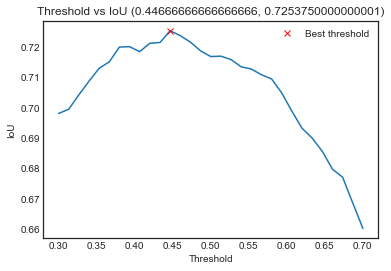

In [24]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [25]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [29]:
x_test = np.array([(np.array(load_img("D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [30]:
preds_test = predict_result(model,x_test,img_size_target)

In [31]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



Usedtime = 6.904564142227173 s


In [32]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission13.csv')